In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_genlaguerre
from math import sqrt, pi, factorial

In [2]:
def LaguerreGauss(p,l,r,phi,w0):
    a = sqrt(2**(abs(l)+1)*factorial(p)/(pi*(w0**2)*factorial(p+abs(l))))
    b = (r/w0)**abs(l)
    c = np.exp(-(r**2)/(w0**2))
    d = eval_genlaguerre(p,abs(l),2*(r**2)/(w0**2))
    return a*b*c*d*np.exp(-l*phi*1j)

In [3]:
pix = 75
w0 = 0.4e-3
X,Y = np.mgrid[-3*w0:3*w0+1e-6:pix*1j, -3*w0:3*w0+1e-6:pix*1j]
r = np.sqrt(X**2+Y**2)
phi = np.arctan2(Y,X)

In [4]:
p = 0
l_range = 10
l_values = np.arange(l_range)
LG_modes = np.zeros((l_range,pix,pix), complex)

for l in range(l_range):
  LG_modes[l,:,:] = LaguerreGauss(p,l,r,phi,w0)

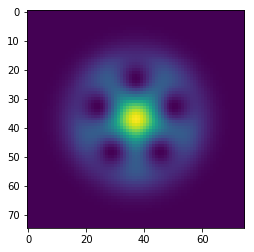

In [5]:
field = LG_modes[0,:,:]+LG_modes[5,:,:]
fig = plt.figure()
plt.imshow(abs(field)**2)

In [6]:
N = 100000 # No of simulated images
sim_field = np.zeros((N,pix,pix), complex)
amps = np.random.rand(N,l_range)
amps_sum = np.sqrt(np.sum(amps**2, axis=1))
amps = amps.transpose()/amps_sum
amps = amps.transpose()
phases = 2*pi*np.random.rand(N,l_range)
weights = amps*np.exp(-phases*1j)
for i in range(N):
  for l in range(l_range):
    sim_field[i,:,:]+=weights[i,l]*LG_modes[l,:,:]

In [7]:
weights[600,:]

array([ 0.00610904+0.00394077j,  0.02621929-0.02036124j,
       -0.19223964+0.20088721j, -0.34738162-0.02819283j,
        0.47339257-0.08985989j,  0.18859322+0.45260687j,
       -0.17027917-0.18822062j,  0.06692158-0.09668001j,
        0.14976952-0.41685935j, -0.07850597-0.21646132j])

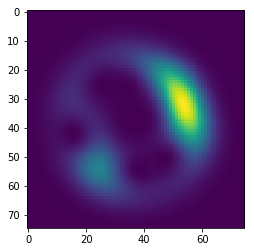

In [8]:
fig = plt.figure()
plt.imshow(abs(sim_field[600,:,:])**2)

In [9]:
sim_images = abs(sim_field)**2

In [10]:
sim_images.shape

(100000, 75, 75)

In [11]:
np.max(sim_images[600,:,:])

1816428.1926454639

In [12]:
sim_images_max = np.max(sim_images, axis=(1,2))

In [13]:
sim_images_max.shape

(100000,)

In [14]:
sim_images = sim_images.transpose()/sim_images_max
sim_images = sim_images.transpose()

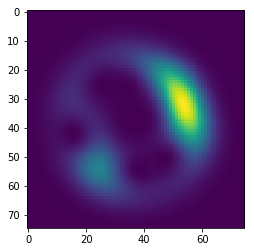

In [15]:
fig = plt.figure()
plt.imshow(sim_images[600,:])

In [16]:
sim_images.shape

(100000, 75, 75)

In [17]:
weights.shape

(100000, 10)

In [18]:
probs = abs(weights)**2

In [19]:
np.max(sim_images)

1.0

In [20]:
np.min(sim_images)

8.712745534407384e-15

In [21]:
np.max(probs)

0.833140643067808

In [22]:
np.min(probs)

5.4101900705059495e-14

In [23]:
sim_images = sim_images - 0.5

In [24]:
from sklearn.model_selection import train_test_split

tr_imgs, te_imgs, tr_probs, te_probs = \
    train_test_split(sim_images, probs, test_size=0.2, random_state=42)

In [25]:
tr_imgs.shape

(80000, 75, 75)

In [26]:
tr_probs.shape

(80000, 10)

In [27]:
tr_imgs = tr_imgs.reshape(tr_imgs.shape[0], pix, pix, 1)
te_imgs = te_imgs.reshape(te_imgs.shape[0], pix, pix, 1)

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [29]:
def make_model():
    
    model = Sequential()

    
    model.add(Conv2D(16,(3,3),padding="same",input_shape=(pix,pix,1)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32,(3,3),padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(32,(3,3),padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64,(3,3),padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(l_range))
    model.add(Activation("softmax"))
    
    
    return model

In [30]:
import tensorflow as tf
import keras
from keras import backend as K


In [31]:
s = K.clear_session()  
model = make_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)      

In [32]:
INIT_LR = 5e-3  
BATCH_SIZE = 32
EPOCHS = 8

s = K.clear_session()  

model = make_model()  


model.compile(
    loss='categorical_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  
    metrics=['categorical_crossentropy']  
)


def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch


class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [33]:
model.fit(
    tr_imgs, tr_probs,  
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), keras.callbacks.callbacks.ProgbarLogger()
               ],
    validation_data=(te_imgs, te_probs),
    shuffle=True,
    verbose=1,
    initial_epoch=0
)


Train on 80000 samples, validate on 20000 samples
Epoch 1/8
Learning rate: 0.005
Epoch 1/8
80000/80000 [==============================] - 73s 909us/step - loss: 2.1022 - categorical_crossentropy: 2.1804 - val_loss: 2.0172 - val_categorical_crossentropy: 2.0172
Epoch 2/8
Learning rate: 0.0045
Epoch 2/8
80000/80000 [==============================] - 62s 771us/step - loss: 2.0173 - categorical_crossentropy: 2.0282 - val_loss: 1.9660 - val_categorical_crossentropy: 1.9660
Epoch 3/8
Learning rate: 0.00405
Epoch 3/8
80000/80000 [==============================] - 62s 771us/step - loss: 1.9905 - categorical_crossentropy: 1.9944 - val_loss: 1.9483 - val_categorical_crossentropy: 1.9483
Epoch 4/8
Learning rate: 0.003645
Epoch 4/8
80000/80000 [==============================] - 62s 771us/step - loss: 1.9779 - categorical_crossentropy: 1.9798 - val_loss: 1.9400 - val_categorical_crossentropy: 1.9400
Epoch 5/8
Learning rate: 0.0032805
Epoch 5/8
80000/80000 [==============================] - 62s 773

In [34]:
probs_pred_test = model.predict_proba(te_imgs)

In [35]:
probs_pred_test.shape

(20000, 10)

In [36]:
te_probs.shape

(20000, 10)

In [37]:
probs_pred_test[600,:]

array([0.1352287 , 0.36962673, 0.05398815, 0.0038672 , 0.03100814,
       0.13193637, 0.18738844, 0.05260244, 0.01967534, 0.01467844],
      dtype=float32)

In [38]:
te_probs[600,:]

array([1.36042449e-01, 3.61655332e-01, 5.26890314e-02, 1.71185788e-07,
       1.71763010e-02, 1.73585579e-01, 1.90778947e-01, 3.65658482e-02,
       1.51726231e-02, 1.63337183e-02])

In [39]:
probs_pred_test[1000,:]

array([0.19900173, 0.18162343, 0.01094513, 0.00591174, 0.02813756,
       0.01831794, 0.08144892, 0.22735557, 0.23058031, 0.01667765],
      dtype=float32)

In [40]:
te_probs[1000,:]

array([0.16440729, 0.18030731, 0.02392762, 0.0024779 , 0.04578665,
       0.00624418, 0.10462187, 0.24610524, 0.18137475, 0.0447472 ])

In [41]:
def rec_img(probs):
    wts = np.sqrt(probs)
    rec_field = np.zeros((pix,pix),complex)
    for l in range(l_range):
        rec_field+=wts[l]*LG_modes[l,:,:]
    return abs(rec_field)**2

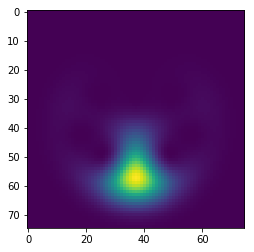

In [42]:
pred_img = rec_img(probs_pred_test[6000,:])
fig = plt.figure()
plt.imshow(pred_img)

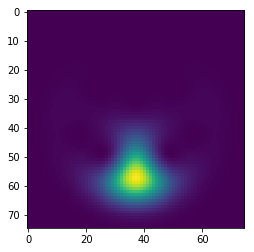

In [43]:
act_img = rec_img(te_probs[6000,:])
fig = plt.figure()
plt.imshow(act_img)

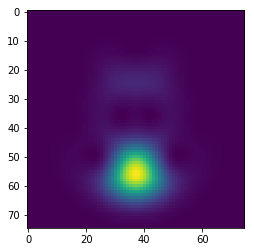

In [44]:
pred_img = rec_img(probs_pred_test[8000,:])
fig = plt.figure()
plt.imshow(pred_img)

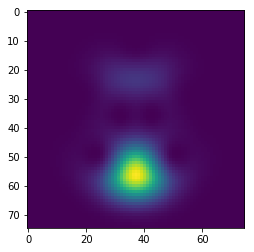

In [46]:
act_img = rec_img(te_probs[8000,:])
fig = plt.figure()
plt.imshow(act_img)

In [ ]:
w = K.clear_session()

The following ResNet implementation is taken from keras.io

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False
num_classes = l_range

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = tr_imgs
x_test = te_imgs

y_train = tr_probs
y_test = te_probs

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

x_train shape: (80000, 75, 75, 1)
80000 train samples
20000 test samples
y_train shape: (80000, 10)

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 75, 75, 16)   0           bat

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


80000/80000 [==============================] - 177s 2ms/step - loss: 2.0711 - accuracy: 0.5997 - val_loss: 2.0790 - val_accuracy: 0.5559
Epoch 3/200
Learning rate:  0.001
80000/80000 [==============================] - 176s 2ms/step - loss: 2.0153 - accuracy: 0.6633 - val_loss: 2.0596 - val_accuracy: 0.6337
Epoch 4/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9875 - accuracy: 0.6900 - val_loss: 2.0064 - val_accuracy: 0.6571
Epoch 5/200
Learning rate:  0.001
80000/80000 [==============================] - 178s 2ms/step - loss: 1.9678 - accuracy: 0.7023 - val_loss: 2.0246 - val_accuracy: 0.6316
Epoch 6/200
Learning rate:  0.001
80000/80000 [==============================] - 178s 2ms/step - loss: 1.9517 - accuracy: 0.7144 - val_loss: 1.9605 - val_accuracy: 0.6992
Epoch 7/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9420 - accuracy: 0.7268 - val_loss: 1.9412 - val_accuracy: 0.7456
Epoch 8/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



80000/80000 [==============================] - 176s 2ms/step - loss: 1.9061 - accuracy: 0.8071 - val_loss: 1.9288 - val_accuracy: 0.7462
Epoch 44/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9058 - accuracy: 0.8086 - val_loss: 1.9748 - val_accuracy: 0.6030
Epoch 45/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9056 - accuracy: 0.8121 - val_loss: 1.9437 - val_accuracy: 0.6808
Epoch 46/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9056 - accuracy: 0.8108 - val_loss: 1.9473 - val_accuracy: 0.6835
Epoch 47/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9056 - accuracy: 0.8124 - val_loss: 1.9196 - val_accuracy: 0.7433
Epoch 48/200
Learning rate:  0.001
80000/80000 [==============================] - 177s 2ms/step - loss: 1.9053 - accuracy: 0.8118 - val_loss: 1.9986 - val_accuracy: 0.4527
Epo